In [1]:
#Use this comand for faster autocompletition in Jupyter notebook
%config Completer.use_jedi = False

In [2]:
#Import libraries
import cv2 #CV2 for converting images to numpy arrays
import numpy as np#prepearing numpy arrays and reshaping them for analysis with CNN
import os#using os for paths
import matplotlib.pyplot as plt#using matplotlib for visualisations

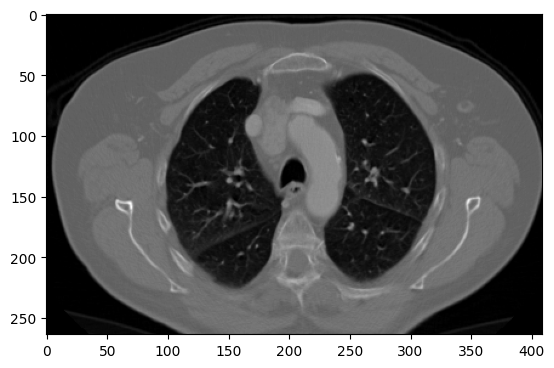

In [3]:
#Check pictures
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

DATADIR = "Data/train"
CATEGORIES = ["adenocarcinoma", "largecellcarcinoma","squamouscellcarcinoma", "normal"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img_array is not None:
            plt.imshow(img_array, cmap="gray")
            plt.show()
        else:
            print(f"Failed to load image: {img_path}")
        break
    break


In [4]:
#We see that image has 3 channels but regarding our case blak and white images would be enough (color do not have any purpose in this case) so we can convert them later to 1 channel and save computational power we will do that with cv2.IMREAD_GRAYSCALE
sample_image_path = os.path.join('Data','train','adenocarcinoma','000000 (6).png')
sample_image = cv2.imread(sample_image_path)
sample_image.shape

(264, 409, 3)

In [5]:
#If we check shapes of all train images we see that they differ widely in width and height so we need to preprocess them before CNN training
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        print(img_array.shape)
        


(264, 409)
(243, 397)
(244, 392)
(220, 377)
(272, 373)
(288, 449)
(276, 389)
(328, 384)
(323, 417)
(247, 341)
(232, 386)
(246, 410)
(250, 390)
(274, 414)
(242, 423)
(269, 419)
(259, 429)
(211, 373)
(305, 413)
(286, 413)
(258, 387)
(284, 377)
(206, 432)
(295, 391)
(296, 396)
(232, 384)
(267, 418)
(313, 410)
(278, 416)
(196, 385)
(244, 345)
(274, 440)
(250, 439)
(240, 400)
(239, 349)
(320, 393)
(310, 449)
(224, 364)
(249, 423)
(258, 338)
(252, 402)
(288, 377)
(309, 369)
(273, 372)
(245, 429)
(269, 393)
(255, 378)
(224, 409)
(280, 388)
(263, 385)
(273, 409)
(249, 368)
(285, 419)
(308, 389)
(243, 420)
(272, 403)
(255, 439)
(248, 309)
(244, 374)
(236, 438)
(263, 397)
(263, 365)
(303, 450)
(281, 404)
(225, 332)
(222, 348)
(280, 401)
(254, 430)
(292, 383)
(203, 376)
(210, 467)
(274, 390)
(263, 357)
(258, 413)
(281, 446)
(291, 398)
(245, 384)
(291, 351)
(231, 327)
(259, 412)
(261, 421)
(297, 440)
(202, 368)
(275, 401)
(317, 432)
(233, 423)
(179, 358)
(276, 372)
(225, 431)
(302, 424)
(221, 368)

In [ ]:
#Now we manualy check on few random images which size of image is visually suitable even for human to detect and chose something similar for CNN later
#For example reshape images to 100px*100px or 50px*50px
IMG_SIZE = [50,100,150,200,250]

for size in IMG_SIZE:
    for img in ['000000 (6).png','000013 (4)','ad7','000121','000106 (8)']:
        sample_image_path = os.path.join('Data','train','adenocarcinoma','000000 (6).png')
        sample_image = cv2.imread(sample_image_path)
        sample_image = cv2.resize(sample_image, (size, size))
        plt.imshow(sample_image,cmap='gray')
        plt.show()

In [9]:
#Import necessery libraries

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16, ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model, load_model,save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model 
from IPython.display import Image

In [ ]:
#Option 1 (not used in this notebook)

#First create training data and convert it into numpy arrays and later do data augmentation using imgaug library : 
    
#Create a training data from train images folder
DATADIR = "Data/train"
CATEGORIES = ["adenocarcinoma", "largecellcarcinoma","squamouscellcarcinoma", "normal"]
NUM_CLASSES = 4
training_data = []
IMG_SIZE = 250

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

# Convert training_data to NumPy arrays
X = np.array([data[0] for data in training_data])
y = np.array([data[1] for data in training_data])

# Normalize the input data
X_train = X.astype('float32') / 255.0

# Perform one-hot encoding on the labels
y_train = tf.keras.utils.to_categorical(y, NUM_CLASSES)

# After we convert train images to numpy arrays we use imgaug library to do data augmentation and make our training set better for training
#It took to much time on local CPU so try to do it on Google Colab using their GPU and later save .npy file localy

#First create an object for augmentation
import imgaug.augmenters as iaa
augmentation_seq = iaa.Sequential([
    iaa.Fliplr(0.5),#flip horizontaly 50% of the images
    iaa.Affine(rotate=(-20,20)),#Rotate the images by -20 to 20 degrees
    iaa.GaussianBlur(sigma=(0,1.0)) # apply Gaussian blur with a sigma between 0 and 1.0
])

#Then apply augmentation on train images and combine results of augmentation with list of original np array list (training_data)
for image,class_numm in training_data:
    augmented_images = augmentation_seq.augment_images([image])
    training_data.extend([(aug_img, class_num) for aug_img in augmented_images])
    
# Option 1: Save newly cerated training_data list with np.save so you do not need next time to lose time on augmentation
np.save('augmented_training_dataset.npy', training_dataset)
#Later you can load it to new script file
training_dataset = np.load('augmented_training_dataset.npy')

#Option 2: Save newly created training_data list with pickle
import pickle
pickle_out = open("training_data.pickle","wb")
pickle.dump(training_data,pickle_out)
pickle_out.close()
#Later oad to other script as
pickle_in = open("training_data.pickle","rb")
X = pickle.load(pickle_in)

#At the end after these parameters of augmentation len(training_data) should be around 614500

In [19]:
#Option 2 (used in this notebook)
#The other way of doing data augmentation is by using keras module ImageDataGenerator that work with raw images and combine that with flow_from_directory to combine augmentation and converting images to numpy arrays in one step
#Input and compare results using different pretrained models a base model (ResNet50, VGG16...)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, VGG16, ResNet101, VGG19, DenseNet201, EfficientNetB4, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model 
from IPython.display import Image



train_path = "Data/train"
test_path = "Data/test"
valid_path = "Data/valid"

#Becuase we choosed that 250px*250px is enough and if we want to use pretrained models like ResNet50 and VGG16 we must leave 3 channels 
#becuase these models are pretrained on RGB images

INPUT_SHAPE = (250,250,3) 
NUM_CLASSES=4
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(250,250),
    batch_size=32,
    class_mode='categorical',
    
)


test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(250,250),
    batch_size=32,
    class_mode='categorical',
)
validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(250,250),
    batch_size=32,
    class_mode='categorical',
)


Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
#Trial Using ResNet50 

#Base of our model will be pretrained ResNet50 (we exclude fully connected layer of ResNet because we will addd that layer and train on our examples of lunc cancer pictures )
base_model = ResNet50(include_top=False,pooling='av',weights='imagenet',input_shape=(INPUT_SHAPE))

#To save pretrained weights of ResNet model we go through all ResNet layers and exclude them from training phase
for layer in base_model.layers:
    layer.trainable = False
    
#Down bellow we add our custom layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization()) # Using batch normalization to normalize samples even after flattening layer
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))#Dropout 50% of neurons to prevent overfitting of a model during training phase
model.add(Dense(NUM_CLASSES,activation='softmax'))#Using softmax for a classification problems between for groups of samples (3 type of carcinoma and normal samples)

#Compiling our hybrid model and trian it
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='lung_cancer_ResNet50.h5',#save the model during training
    monitor='val_loss',#we are choosing best model by evaluating val_loss
    save_best_only=True,#only the weights of the best model will be saved 
    verbose=1
)
earlystop = EarlyStopping( #Define model to stop if we do not have relative decreasing of val_loss and put patience to stop after 3 epochs
    patience=3,
    verbose=1 
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

In [ ]:
#Now we test our model that was trained 10 epochs on test images and we get 64% accuracy with ResNet50
result = model.evaluate(test_generator)

In [ ]:
#Plot the model to see train and validation accuracy 
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')

plt.legend(loc='right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
#Trial VGG16 model

base_model= VGG16(include_top = False,pooling='avg',weights='imagenet',input_shape=(INPUT_SHAPE))

for layer in vgg_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='VGG16.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=5,
    verbose=1
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

In [ ]:
#With VGG16 we get only 58% accuracy 
result = model.evaluate(test_generator)

In [ ]:
#Trial using EfficientNetB4 model

INPUT_SHAPE = (250,250,3)

base_model= EfficientNetB4(include_top = False,pooling='avg',weights='imagenet',input_shape=(INPUT_SHAPE))

for layer in effb4_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath='origin_effnetb4_50epochs.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

In [ ]:
#After 50 epochs we got a model taht we saved as effnetb4_50epochs.h5 with test accuracy of average 78% (68% after 10 epochs so retrained on 50 epochs). This model is used in the aplication.
result = model.evaluate(test_generator)

In [10]:
#Checking if model was accurately saved and loading it
imported_model = load_model('model_effnetb4_50epochs.h5')

In [41]:
#Testing on unknown single samples (creating functions for the aplication)
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input


CATEGORIES = ["adenocarcinoma", "largecellcarcinoma", "squamouscellcarcinoma", "normal"]
INPUT_SHAPE = (250, 250, 3) #input shape that we used for training a model

def preprocess(filepath):
    img = cv2.imread(filepath)
    img = cv2.resize(img, (INPUT_SHAPE[1], INPUT_SHAPE[0]))
    img = np.reshape(img, (1,) + INPUT_SHAPE)
    img = preprocess_input(img) #using same preprocess_input that we used when we prepeared samples for model training
    return img

def predict_single_image(filepath, imported_model):
    img = preprocess(filepath)
    prediction = imported_model.predict(img)
    predicted_class_index = np.argmax(prediction[0])
    predicted_class = CATEGORIES[predicted_class_index]
    return predicted_class

# Usage example
image_filepath = "filepath"
imported_model = load_model('model_effnetb4_50epochs.h5')
predicted_class = predict_single_image(image_filepath, imported_model)
print("Predicted class:", predicted_class)



1/1 [==============================] - 2s 2s/step
Predicted class: normal
